# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed = 0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

2024-06-15 22:26:22.290527: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 22:26:22.322975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 22:26:22.323009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 22:26:22.323974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 22:26:22.328976: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 22:26:22.329623: I tensorflow/core/platform/cpu_feature_guard.cc:1

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [3]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels) # transform the array of labels into a matrix with as many columns as there are classes
# It's not binary, it's an encoding of the labels (categorical) for the cross-entropy loss function 

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


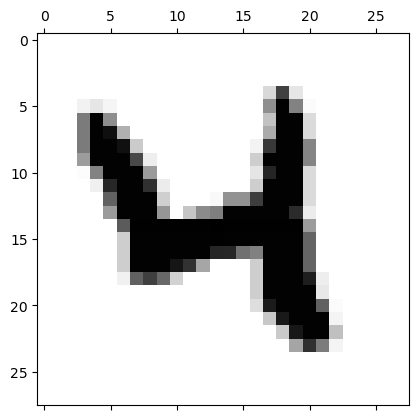

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) # reshape input image to a vector
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1] (normalize)
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary') # reshape back to 28x28 and display it as a figure
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model 
    model = Sequential() # standard feed-forward model (input->hidden->output)
    # add a dense all-to-all relu layer, input dim= 784 = 28*28
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model, i.e. define loss, optimizer and metrics
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc']) 
    return model
    # use stochastic gradient descent as optimizer, categorical cross entropy as loss function and accuracy as metric to monitor during training

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7727 - acc: 0.7743 - val_loss: 0.3161 - val_acc: 0.9124
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3833 - acc: 0.8915 - val_loss: 0.2396 - val_acc: 0.9305
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3066 - acc: 0.9141 - val_loss: 0.1998 - val_acc: 0.9402
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2623 - acc: 0.9269 - val_loss: 0.1737 - val_acc: 0.9475
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2317 - acc: 0.9352 - val_loss: 0.1564 - val_acc: 0.9526


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 0s 864us/step - loss: 0.1564 - acc: 0.9526

Test loss: 0.1564473807811737
Test accuracy: 0.9526000022888184


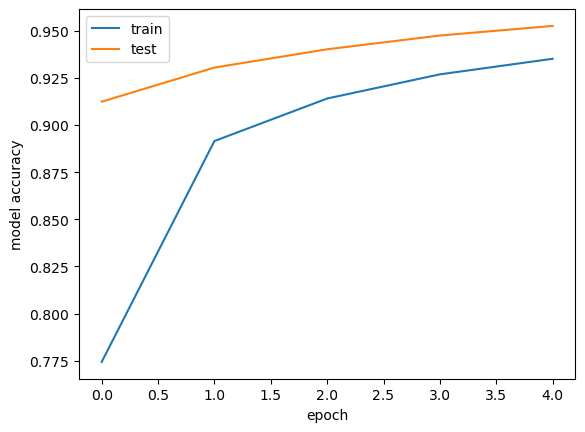

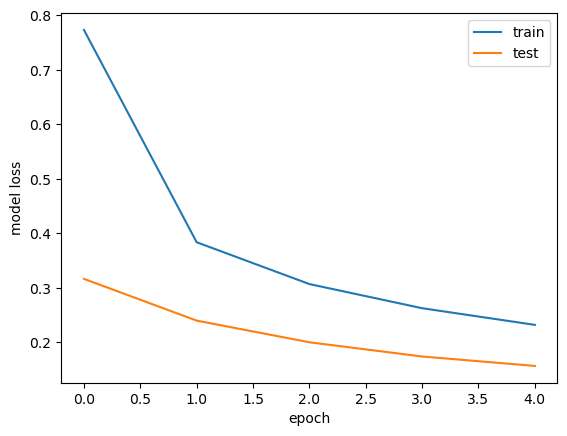

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 [==============================] - 0s 915us/step


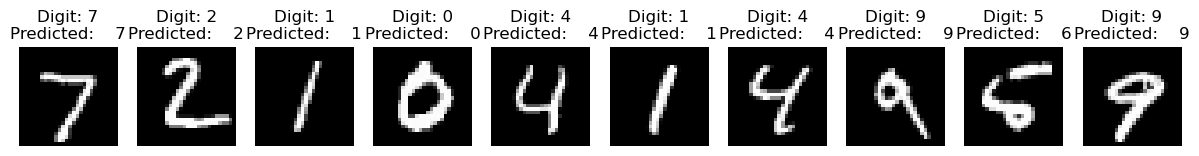

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

For a fair comparison i kept everything the same and changed only the optimizer used and doing 50 epochs each.

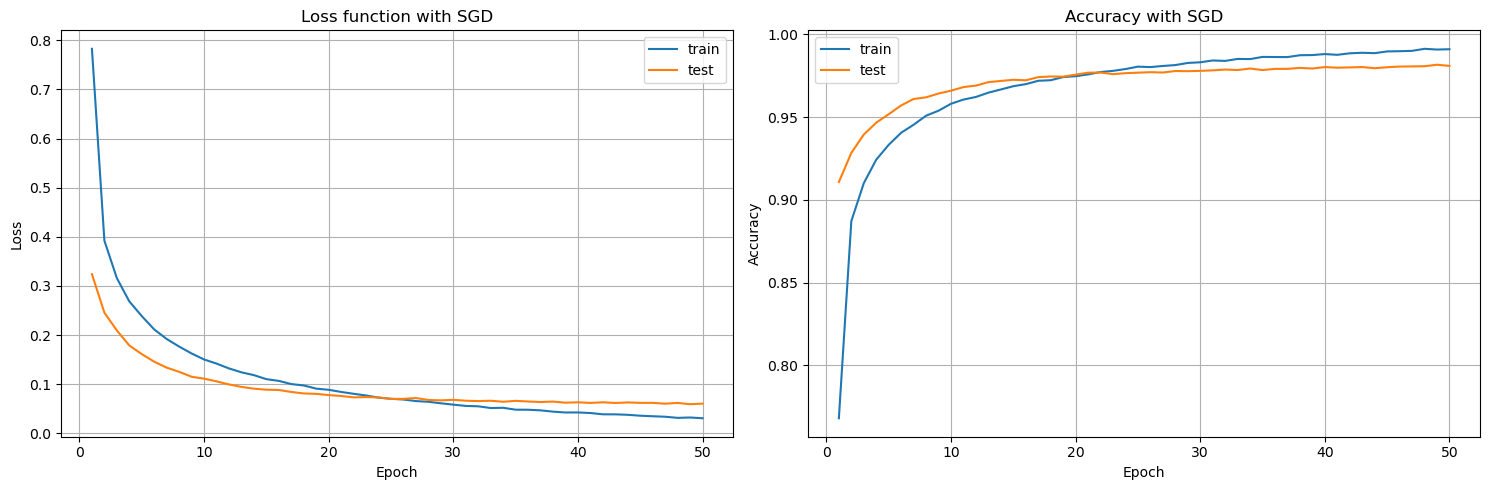

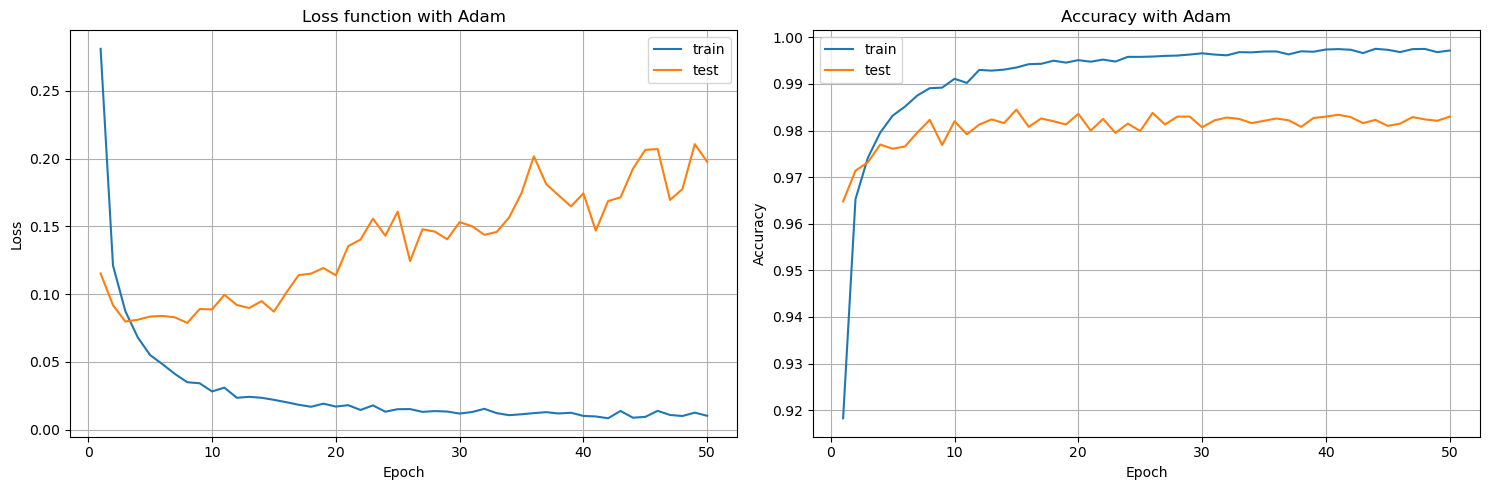

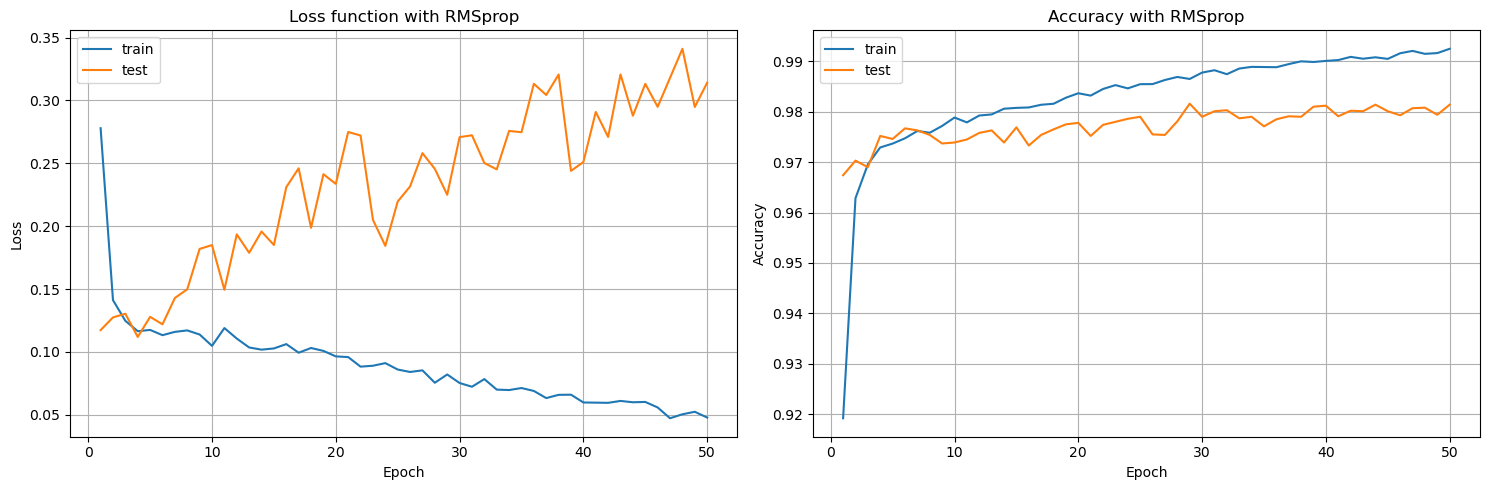

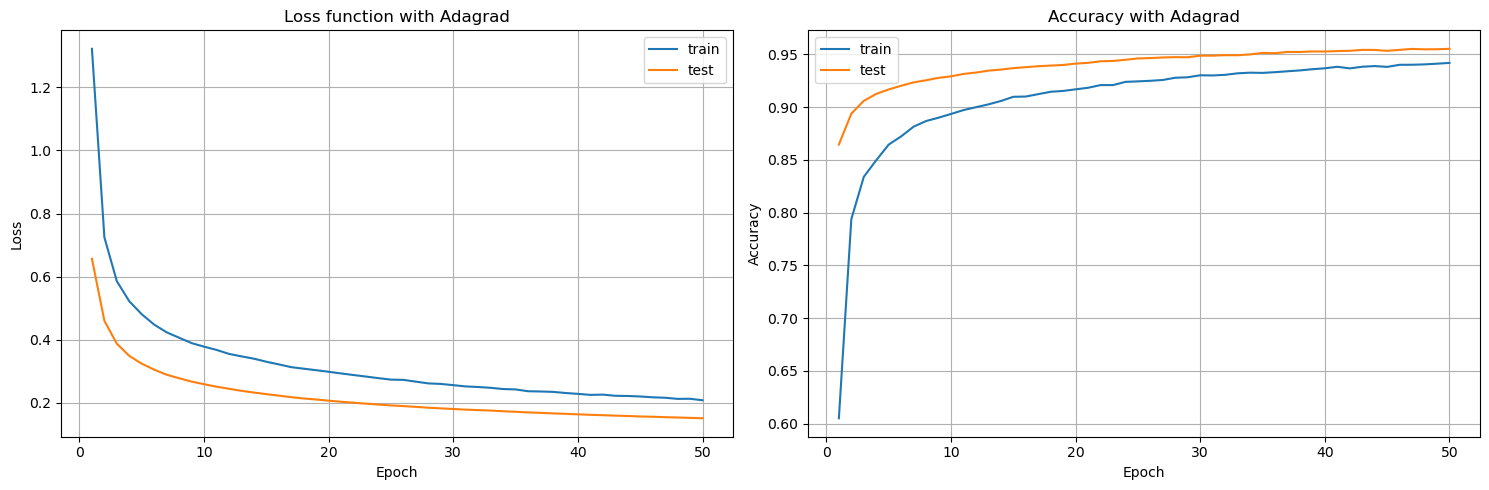

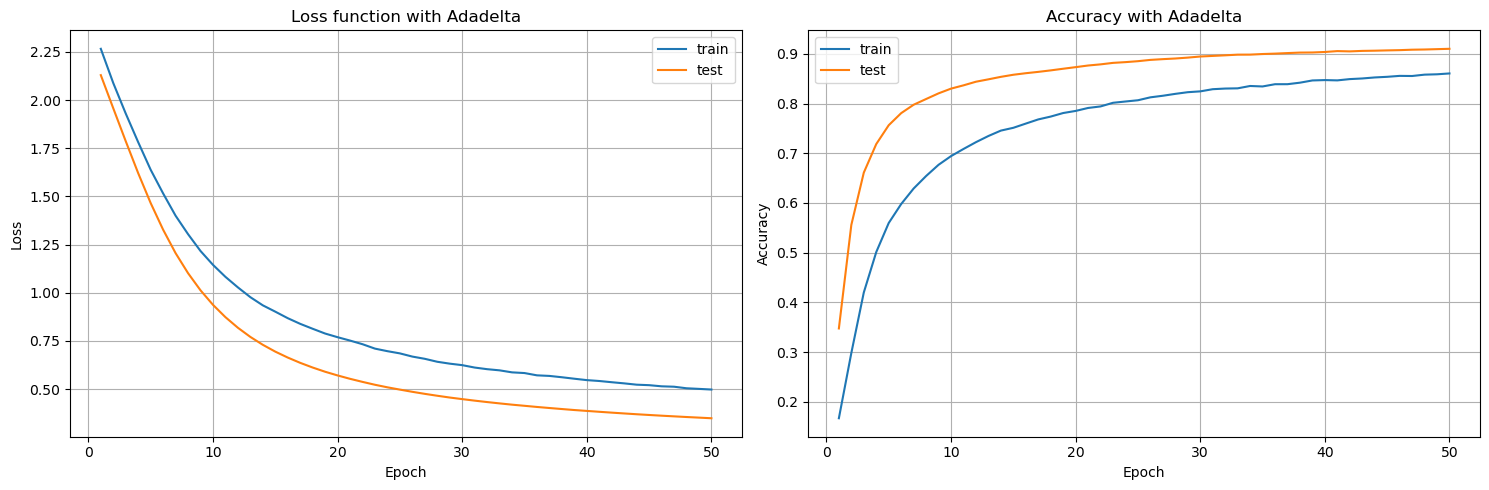

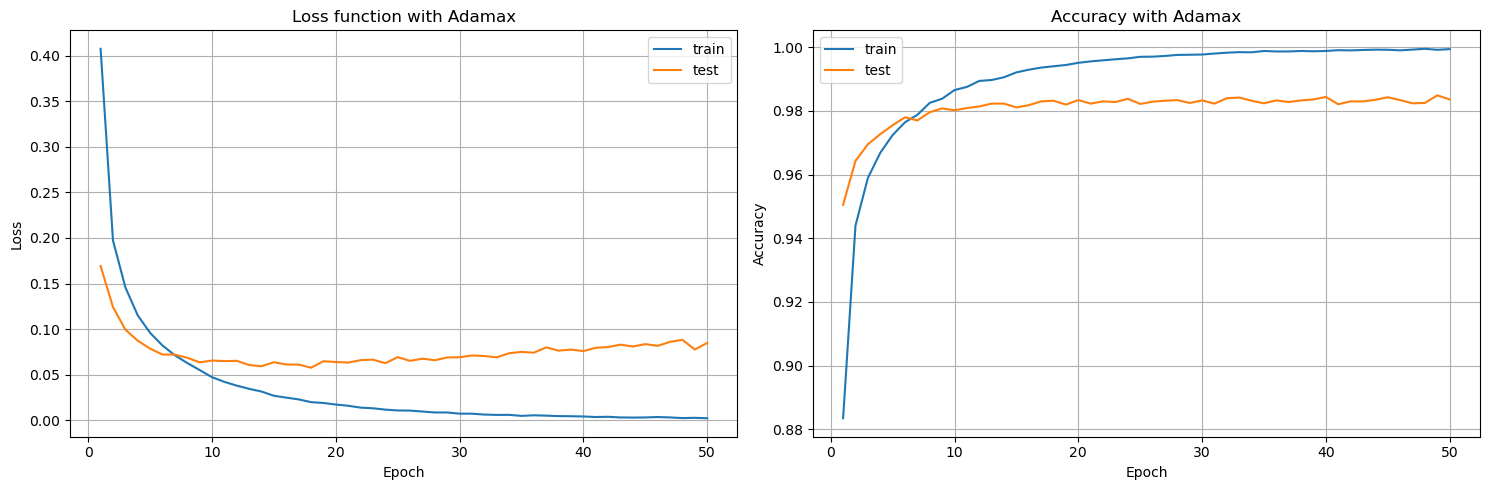

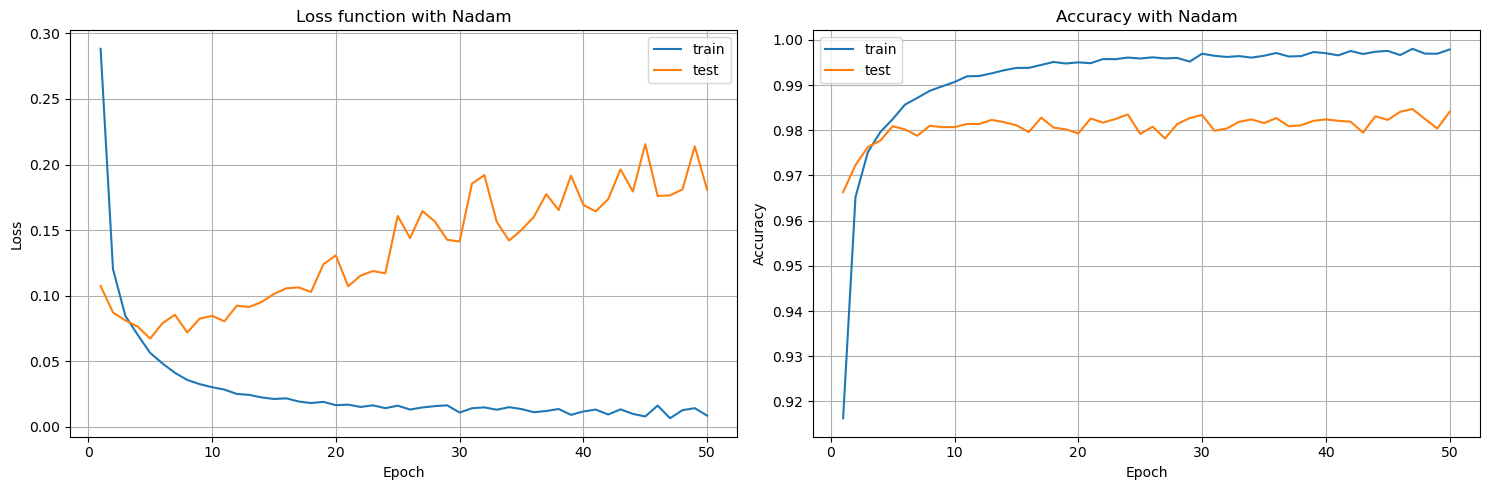

In [10]:
# plot results for various optimizers

optimizer = ['SGD', 'Adam', 'RMSprop', 'Adagrad','Adadelta','Adamax', 'Nadam']

for i,opt in enumerate(optimizer):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    epoch, loss, val_loss, acc, val_acc = np.loadtxt(f'DATA/optimizer/{opt}.dat', unpack=True, delimiter=' ', skiprows=1)
    ax[0].plot(epoch, loss, label='train')
    ax[0].plot(epoch, val_loss, label='test')
    ax[0].set_title(f'Loss function with {opt}')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(epoch, acc, label='train')
    ax[1].plot(epoch, val_acc, label='test')
    ax[1].set_title(f'Accuracy with {opt}')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()


313/313 [==============================] - 0s 984us/step


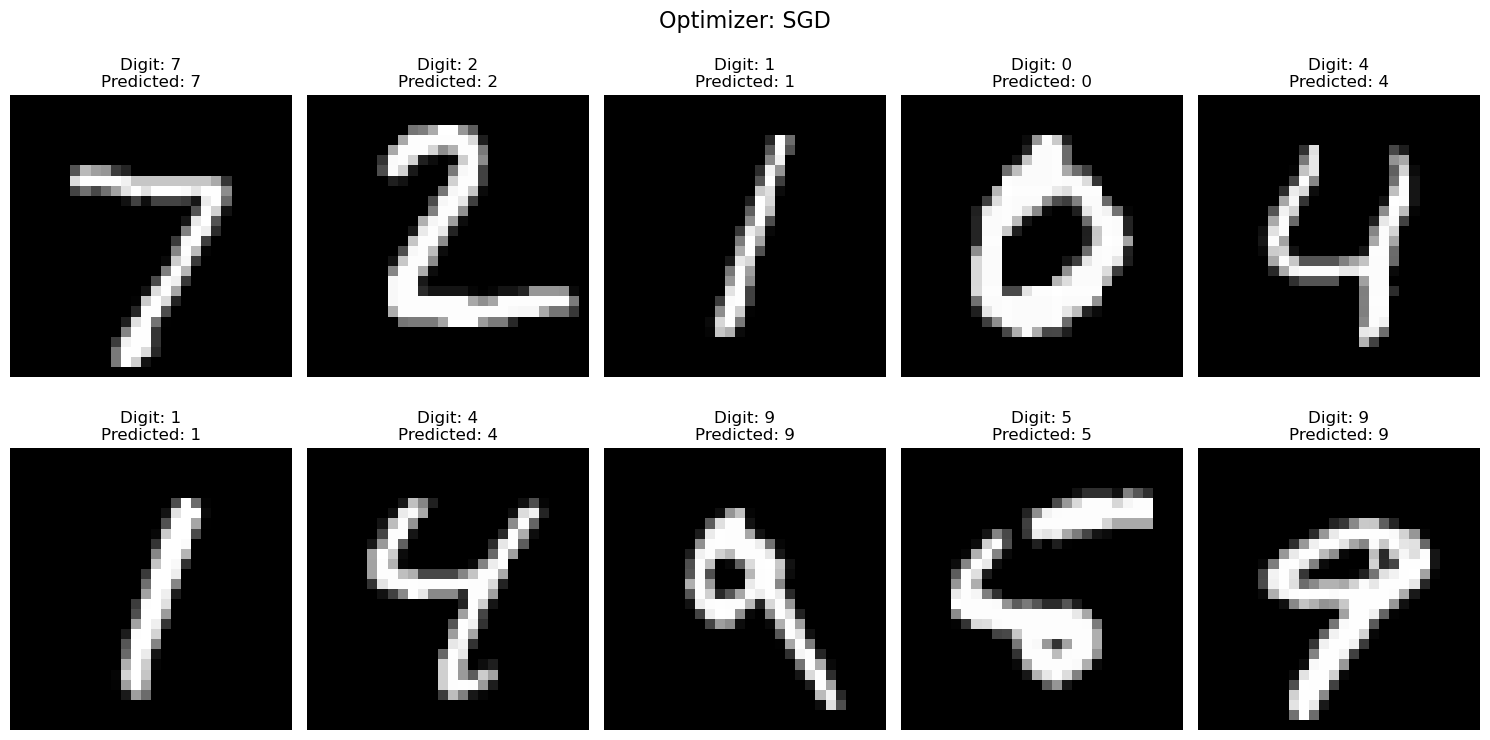

313/313 [==============================] - 0s 919us/step


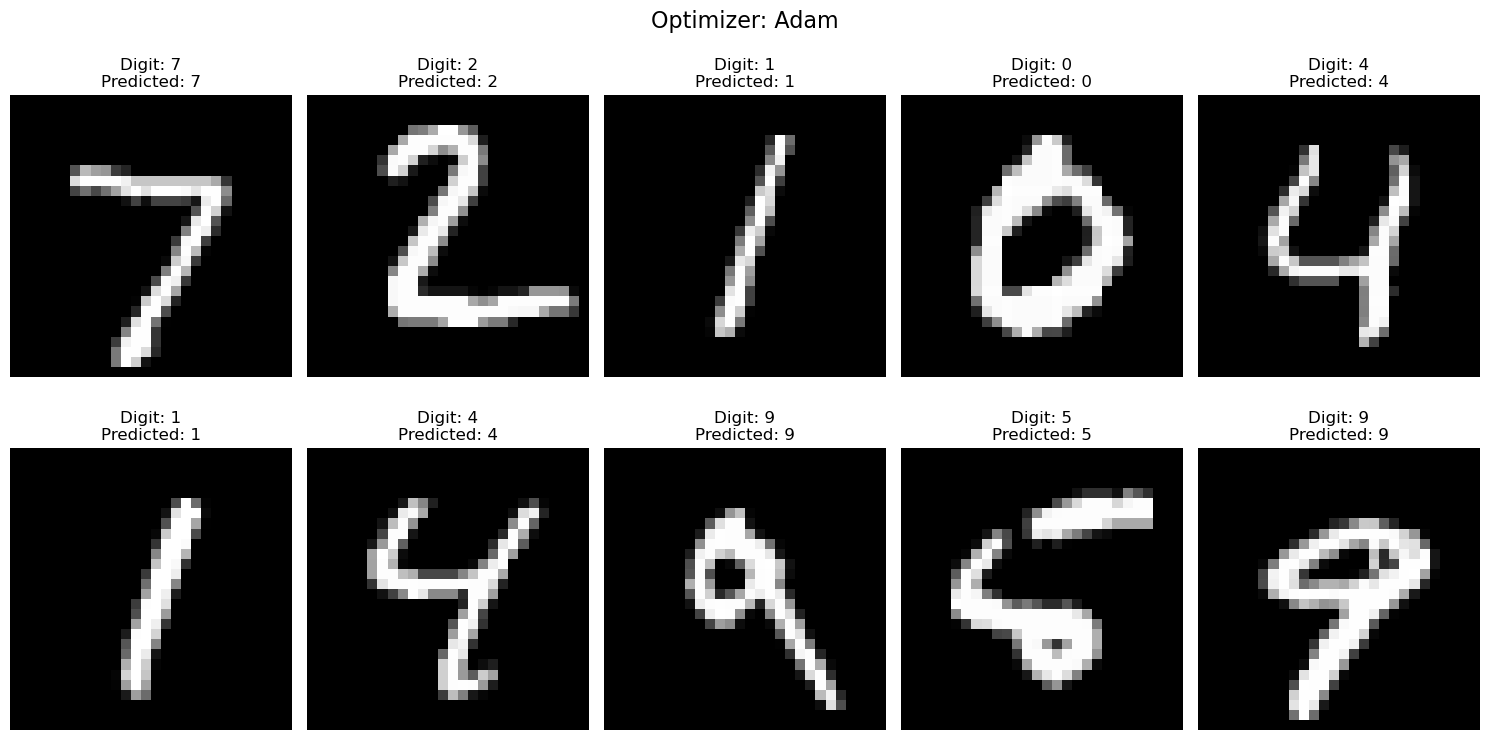

313/313 [==============================] - 0s 911us/step


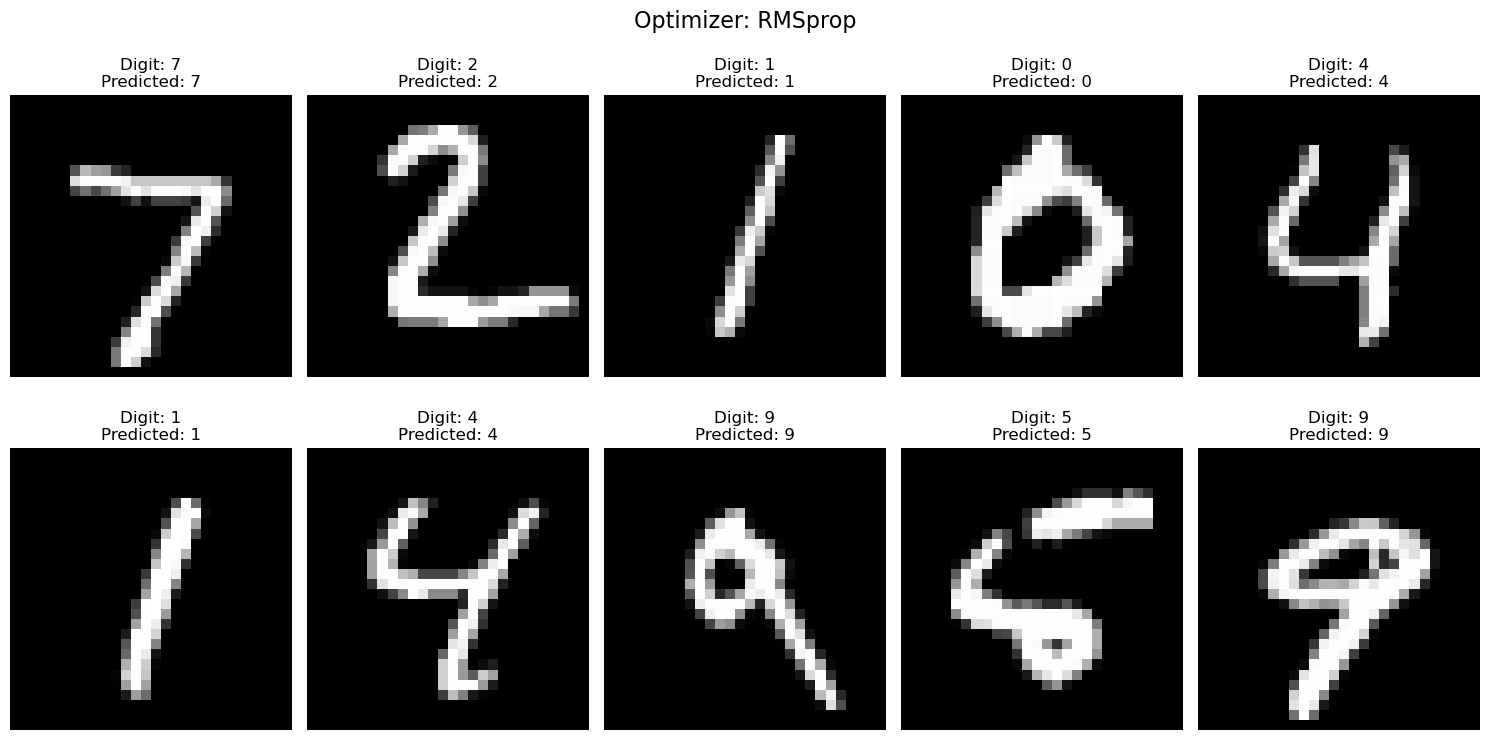

313/313 [==============================] - 0s 1ms/step


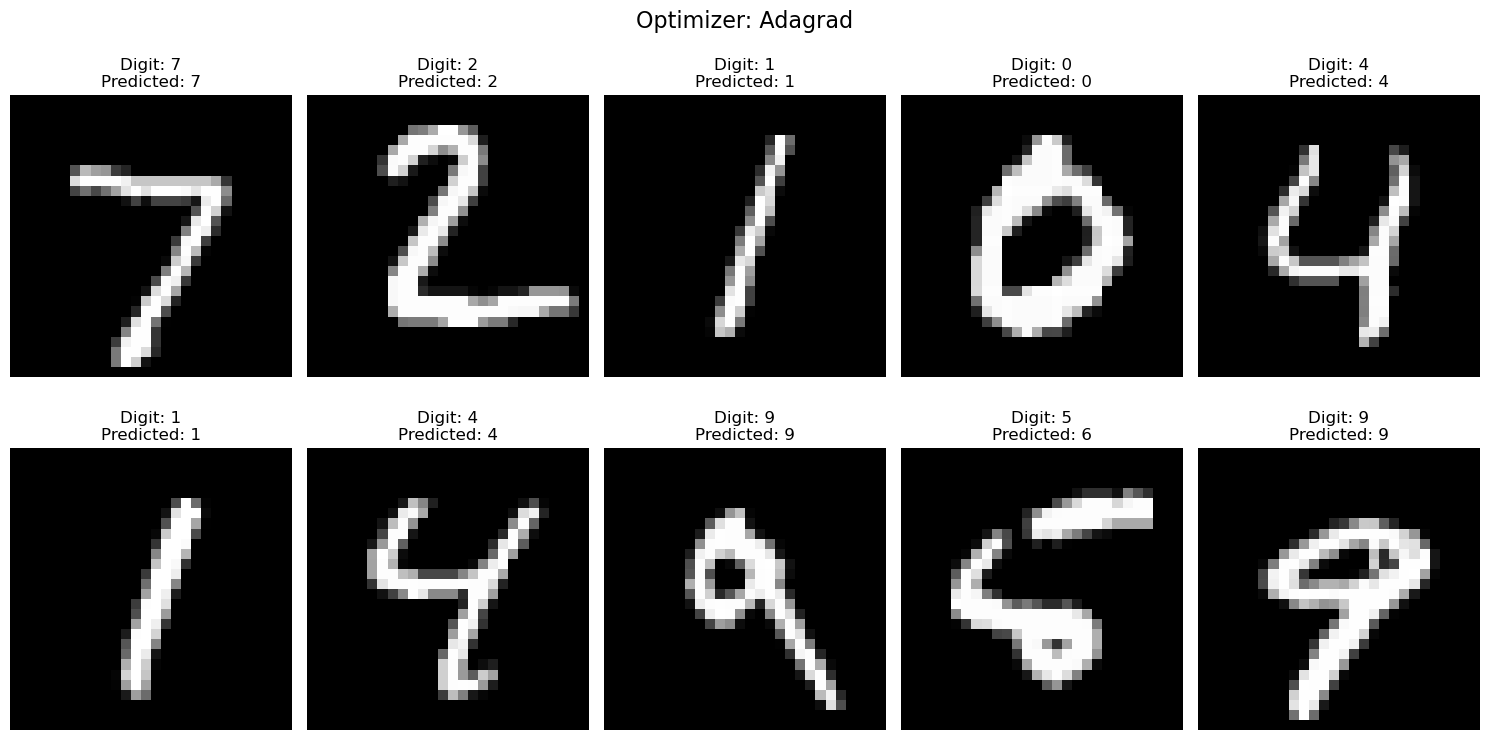

313/313 [==============================] - 0s 938us/step


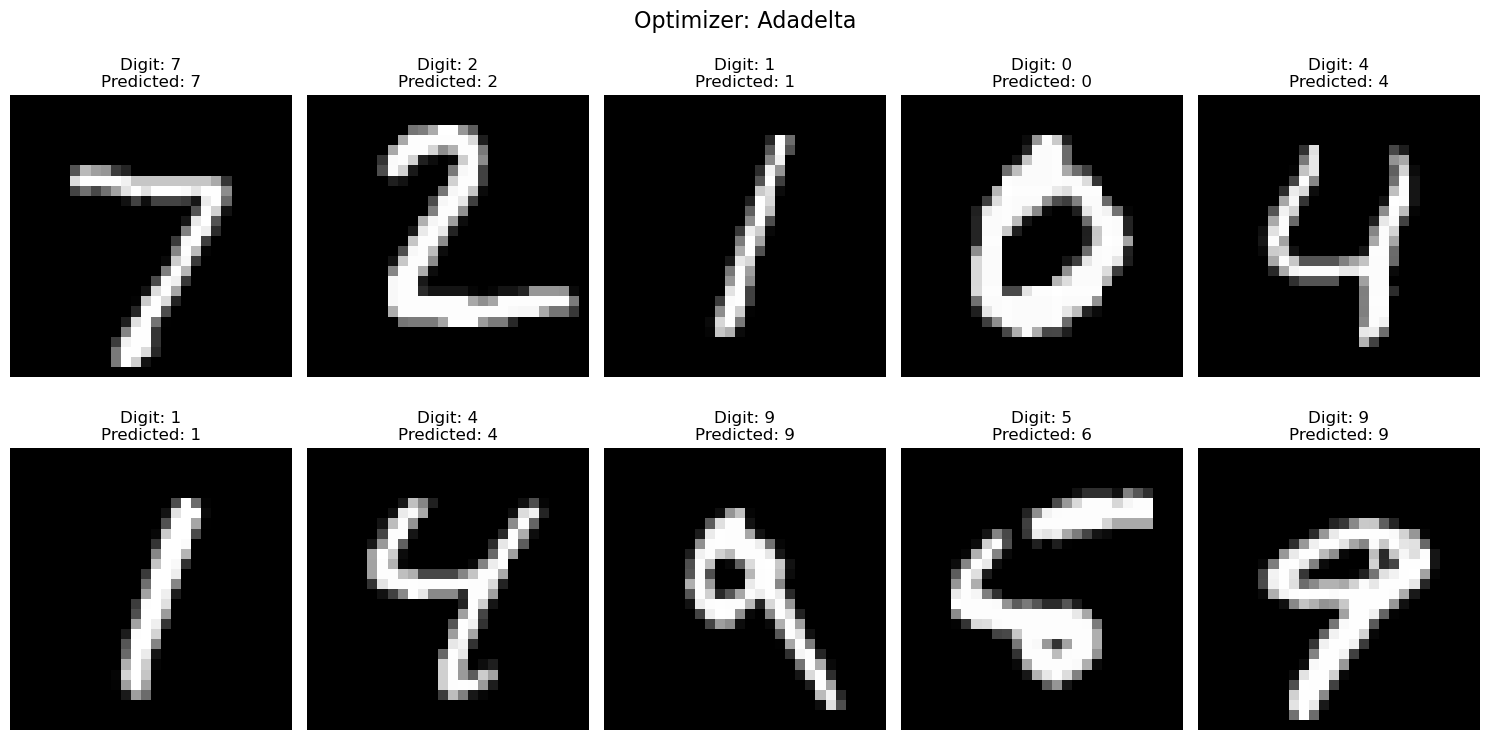

313/313 [==============================] - 0s 905us/step


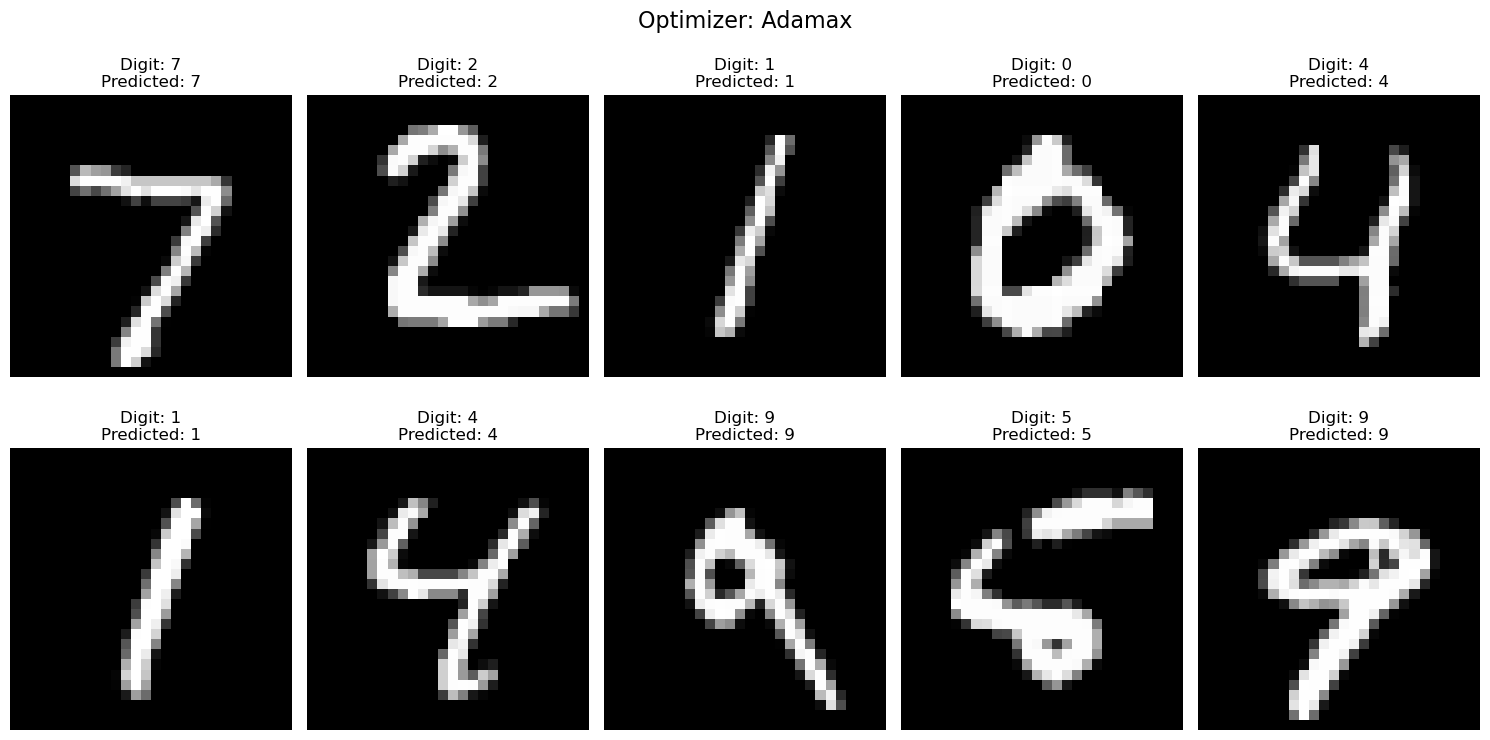

313/313 [==============================] - 0s 1ms/step


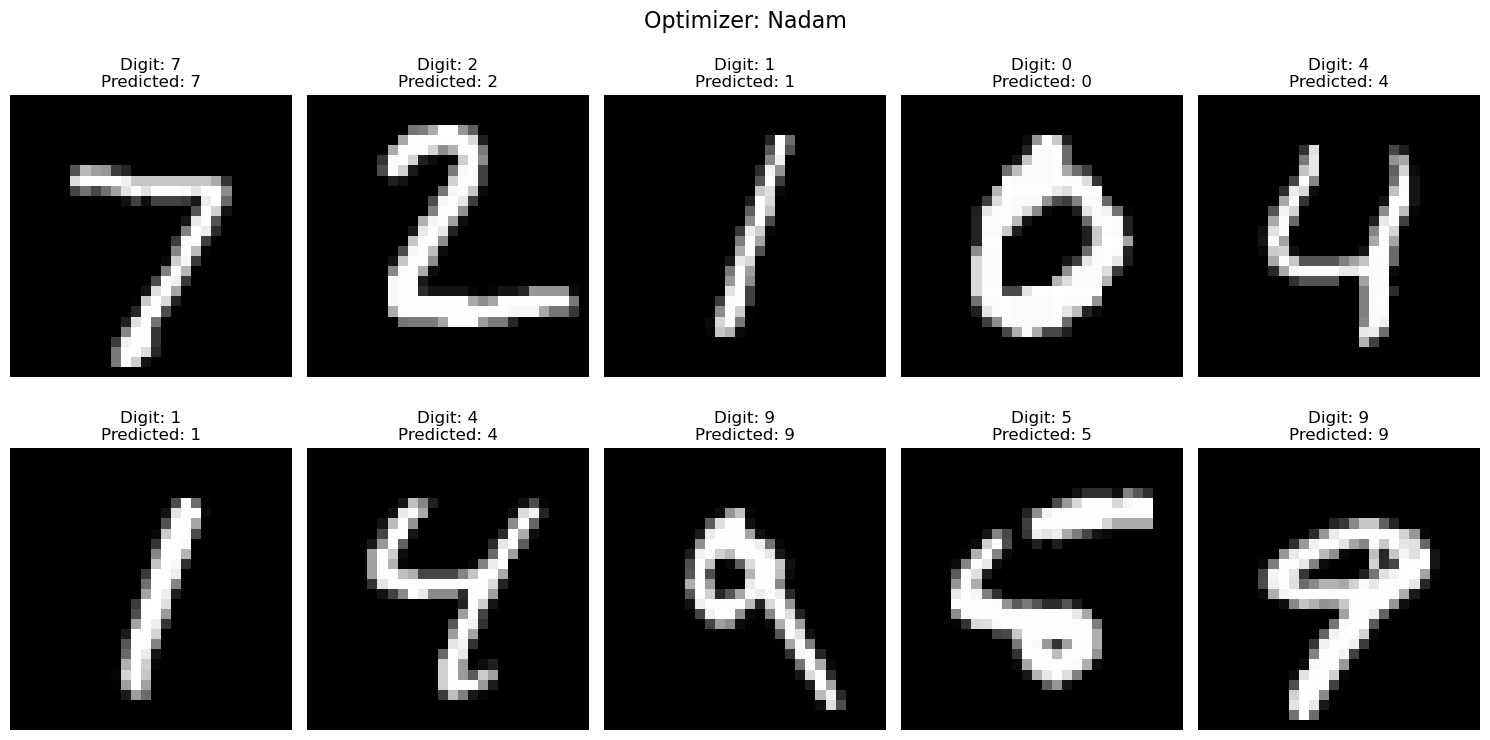

In [11]:
# Loading Data from mnist again
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])

keras.utils.to_categorical(labels)

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) # reshape input image to a vector
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1] (normalize)
X_train /=255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
X_train = keras.utils.to_categorical(Y_test, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

for opt in optimizer:
    # Load the model
    model = tf.keras.models.load_model(f'DATA/models/DNN/{opt}.h5')
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Reshape X_test if required (assuming img_rows and img_cols are defined)
    X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    
    # Plot the images and predictions
    plt.figure(figsize=(15, 8))
    plt.suptitle(f'Optimizer: {opt}', fontsize=16)
    
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')
        plt.title(f"Digit: {np.argmax(Y_test[i])}\nPredicted: {np.argmax(predictions[i])}")
        plt.axis('off')
        
    plt.tight_layout()  # Leave space for suptitle
    plt.show()

I used the default setting for all of them, and from these plots i see that for Adagrad and Adadelta, validation_loss is always less than training_loss, this means that i haven't reached the point of overlearning and there's still room for improvement, in fact the accuracy are lower compared to other optimizers that passed beyong the point of overlearning. 

One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

__Convolutional Neural Network (CNN) Structure__

The following describes the architecture of the CNN defined by the create_CNN function:

1. __Input Layer__
    - __Shape__: (64, 64, 3) (example for 64x64 RGB images)
    - __Explanation__: The input layer takes images of size 64x64 with 3 color channels (RGB).

2. First Convolutional Layer
    - __Layer__: Conv2D(10, kernel_size=(5, 5), activation='relu')
    - __Shape__: (60, 60, 10) (since a 5x5 filter reduces each dimension by 4)
    - __Explanation__: Applies 10 convolutional filters of size 5x5, extracting features with ReLU activation.

3. Second Convolutional Layer
    - __Layer__: Conv2D(20, kernel_size=(5, 5), activation='relu')
    - __Shape__: (56, 56, 20) (another reduction by 4 per dimension)
    - __Explanation__: Applies 20 convolutional filters of size 5x5 for deeper feature extraction.

3. First Max-Pooling Layer
    - __Layer__: MaxPooling2D(pool_size=(2, 2))
    - __Shape__: (28, 28, 20) (halves each dimension)
    - __Explanation__: Reduces spatial dimensions, retaining important features while reducing computation.

4. First Dropout Layer
    - __Layer__: Dropout(0.25)
    - __Shape__: (28, 28, 20) (unchanged)
    - __Explanation__: Randomly sets 25% of inputs to zero, reducing overfitting.

5. Third Convolutional Layer
    - __Layer__: Conv2D(50, kernel_size=(3, 3), activation='relu')
    - __Shape__: (26, 26, 50) (3x3 filter reduces each dimension by 2)
    - __Explanation__: Applies 50 convolutional filters of size 3x3 for more complex feature extraction.

6. Second Max-Pooling Layer
    - __Layer__: MaxPooling2D(pool_size=(2, 2))
    - __Shape__: (13, 13, 50) (halves each dimension again)
    - __Explanation__: Further reduces spatial dimensions and computation.

7. Second Dropout Layer
    - __Layer__: Dropout(0.25)
    - __Shape__: (13, 13, 50) (unchanged)
    - __Explanation__: Randomly sets 25% of inputs to zero, further reducing overfitting.

8. Flatten Layer
    - __Layer__: Flatten()
    - __Shape__: (8450,) (flattens the 3D tensor into a 1D vector)
    - __Explanation__: Converts the 2D matrix into a 1D vector for the fully connected layers.

9. First Fully Connected (Dense) Layer
    - __Layer__: Dense(128, activation='relu')
    - __Shape__: (128,)
    - __Explanation__: Fully connected layer with 128 neurons and ReLU activation for classification.

10. Third Dropout Layer
    - __Layer__: Dropout(0.5)
    - __Shape__: (128,) (unchanged)
    - __Explanation__: Randomly sets 50% of inputs to zero, preventing overfitting.

11. Output Layer
    - __Layer__: Dense(num_classes, activation='softmax')
    - __Shape__: (num_classes,)
    - __Explanation__: Fully connected layer with softmax activation for multi-class classification.

__Explanation of Structure__

- __Convolutional Layers__: Extract hierarchical features from input images. Early layers capture low-level features (e.g., edges), while deeper layers capture high-level features (e.g., shapes).
- __Pooling Layers__: Reduce spatial dimensions, improving computational efficiency and providing spatial invariance.
- __Dropout Layers__: Regularize the model by preventing overfitting, making it more generalizable.
- __Fully Connected Layers__: Perform classification based on the features extracted by the convolutional layers.
- __Softmax Output__: Outputs a probability distribution over the num_classes categories, suitable for classification tasks.

In [12]:
# Load model from DATA/models/CNN
model_CNN = tf.keras.models.load_model(f'DATA/models/CNN/model_CNN1.keras')
model_CNN.summary()  # Print the model summary to verify the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 10)        260       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 20)        5020      
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 20)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 20)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 50)          9050      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 50)          0         
 g2D)                                                   

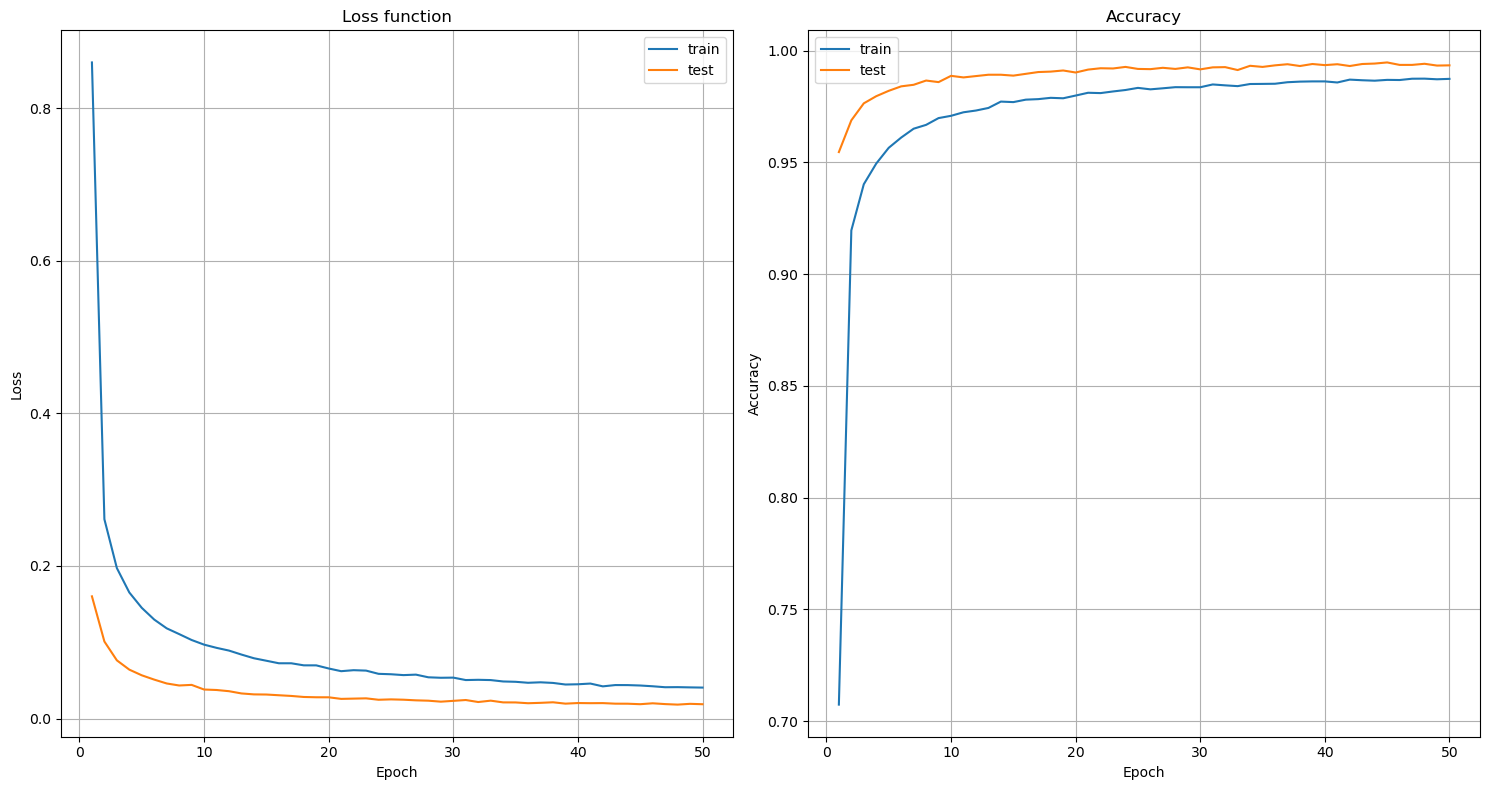

In [13]:
# history DCNN.dat
epoch, loss, val_loss, acc, val_acc = np.loadtxt(f'DATA/DCNN.dat', unpack=True, delimiter=' ', skiprows=1)

# Plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(epoch, loss, label='train')
ax[0].plot(epoch, val_loss, label='test')
ax[0].set_title('Loss function')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()
ax[0].grid(True)
ax[1].plot(epoch, acc, label='train')
ax[1].plot(epoch, val_acc, label='test')
ax[1].set_title('Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend()
ax[1].grid(True)
plt.tight_layout()
plt.show()

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

In [14]:
# Load MNIST data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Define the image dimensions
img_rows, img_cols = 28, 28

# Reshape the data (flattened to 2D array if necessary)
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Convert data type to float32 and normalize the values to [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 10
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('X_train shape:', X_train.shape)

X_train shape: (60000, 28, 28, 1)


313/313 [==============================] - 1s 3ms/step


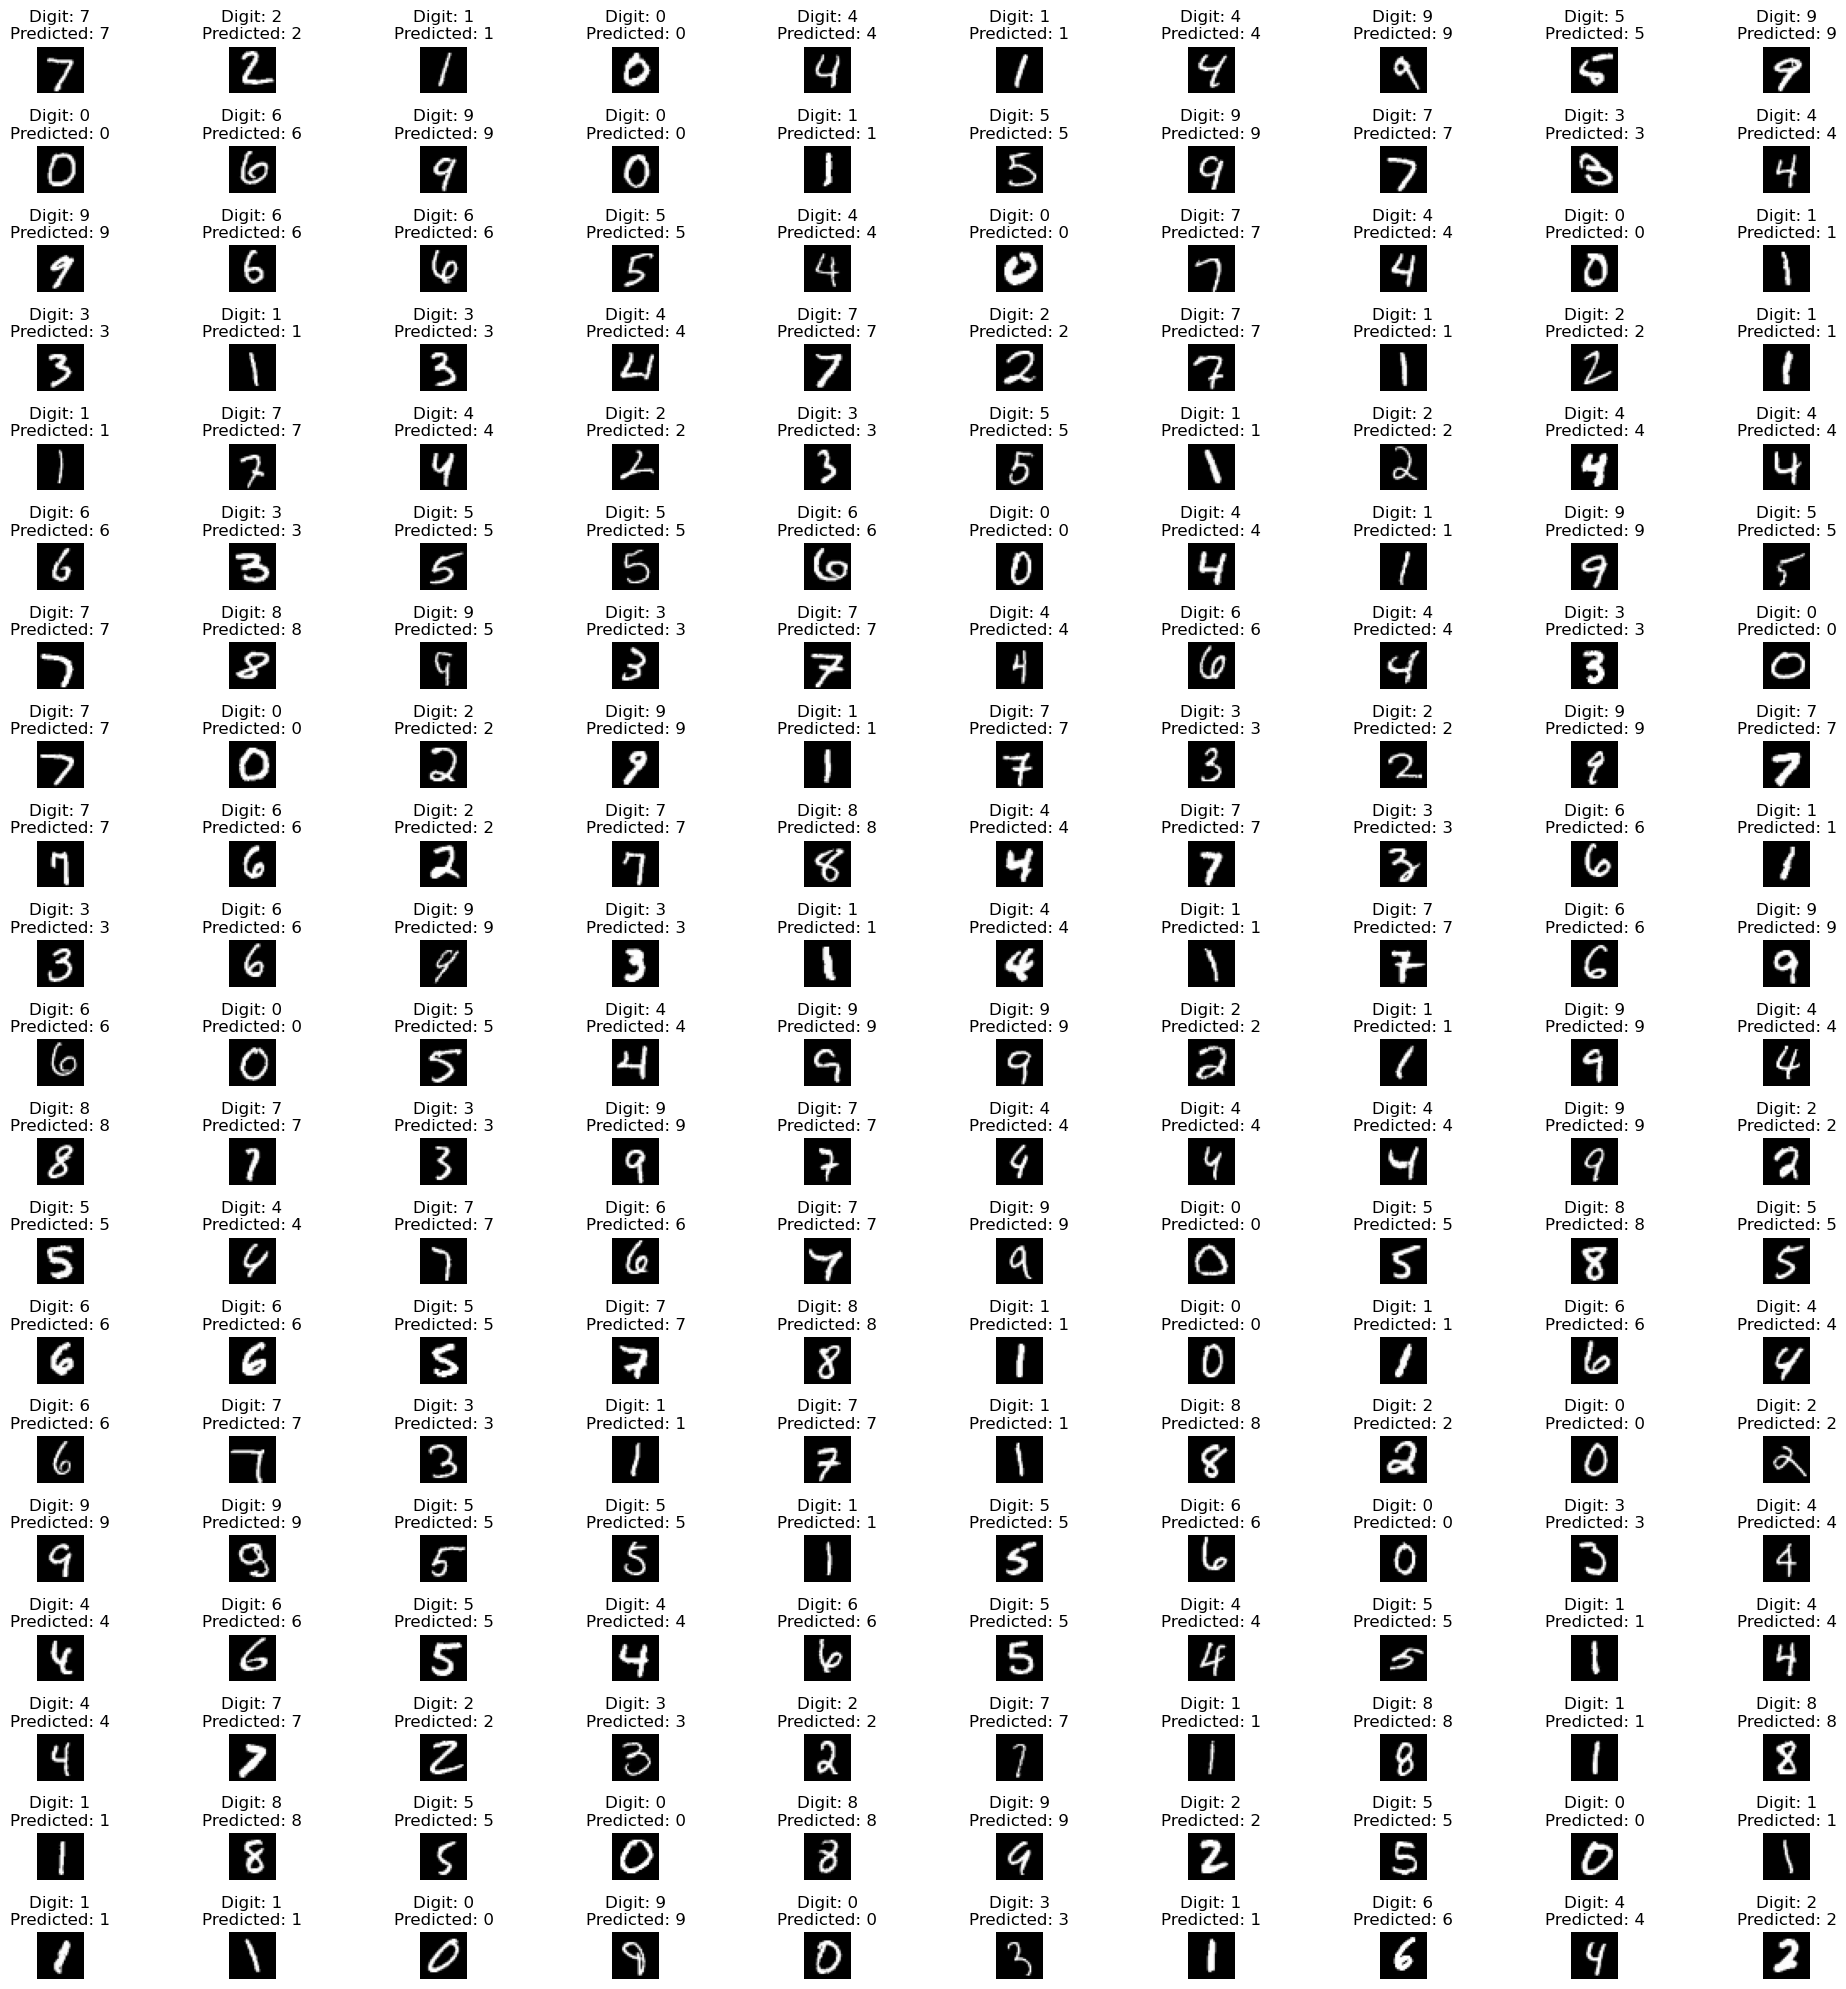

In [15]:
# X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

# Number of images to plot
num_images = 200
# Determine the grid size for plotting
num_rows = 20
num_cols = 10

# Plot the specified number of test images along with their true and predicted labels
plt.figure(figsize=(20, 20))
for i in range(num_images):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.tight_layout()
plt.show()


### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [16]:
# TO LOAD FILES ON GOOGLE COLAB
#from google.colab import files
#upload = files.upload() #this will let you browse and choose the file to be uploaded

Image size: 28x28


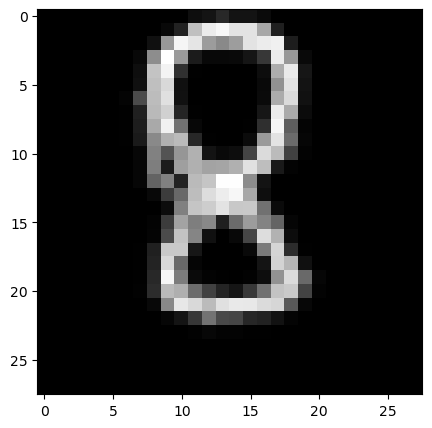

(28, 28)


In [20]:
from PIL import Image
import os

digit_filename = "./Pictures/8.png"
digit_in = Image.open(digit_filename).convert('L') # convert to grayscale, 'L' format means each pixel is represented by a single value from 0 to 255
#digit_in = Image.open("8b.png").convert('L') #ON GOOGLE COLAB INSERT THE NAME OF THE UPLOADED FILE

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load()
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

plt.figure(figsize=(5,5))
plt.imshow(data, cmap='gray')
plt.show()

print(data.shape)

I use the previously trained CNN to predict the digit:

(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 16ms/step


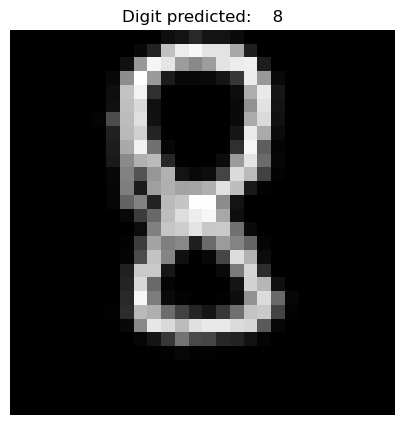

In [21]:
print(data.shape)
data = data.reshape(1,xdim,ydim,1)
print(data.shape)
pred_0 = model_CNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

1/1 [==============================] - 0s 18ms/step


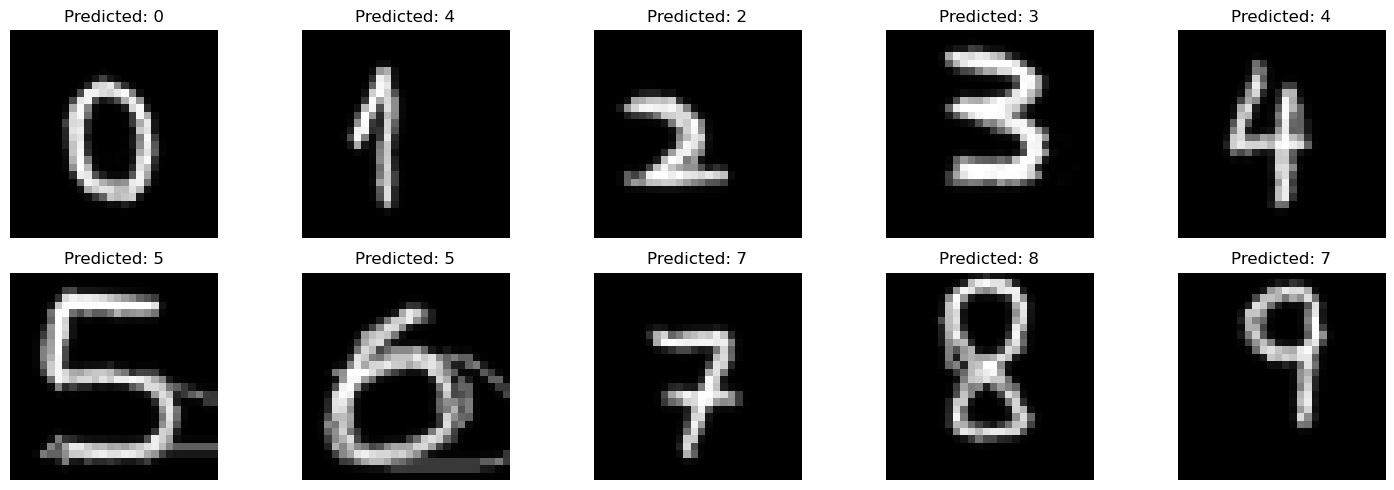

In [24]:
#now we can try to predict the other digits 

digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a figure with multiple subplots arranged in a single row
plt.figure(figsize=(15, 5))

# Loop through each digit and plot the prediction
for idx, digit in enumerate(digits, start=1):
    # Load the digit image and preprocess it
    digit_filename = f"./Pictures/{digit}.png"
    digit_in = Image.open(digit_filename).convert('L') # convert to grayscale
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]

    data /= 255

    # Reshape the data and make prediction
    data = data.reshape(1, xdim, ydim, 1)
    pred = model_CNN.predict(data)

    # Reshape the data for visualization
    data = data.reshape(xdim, ydim)

    # Plot the digit and its predicted label in a subplot
    plt.subplot(2, 5, idx)
    plt.imshow(data, cmap='gray')
    plt.title(f"Predicted: {np.argmax(pred)}")
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 17ms/step


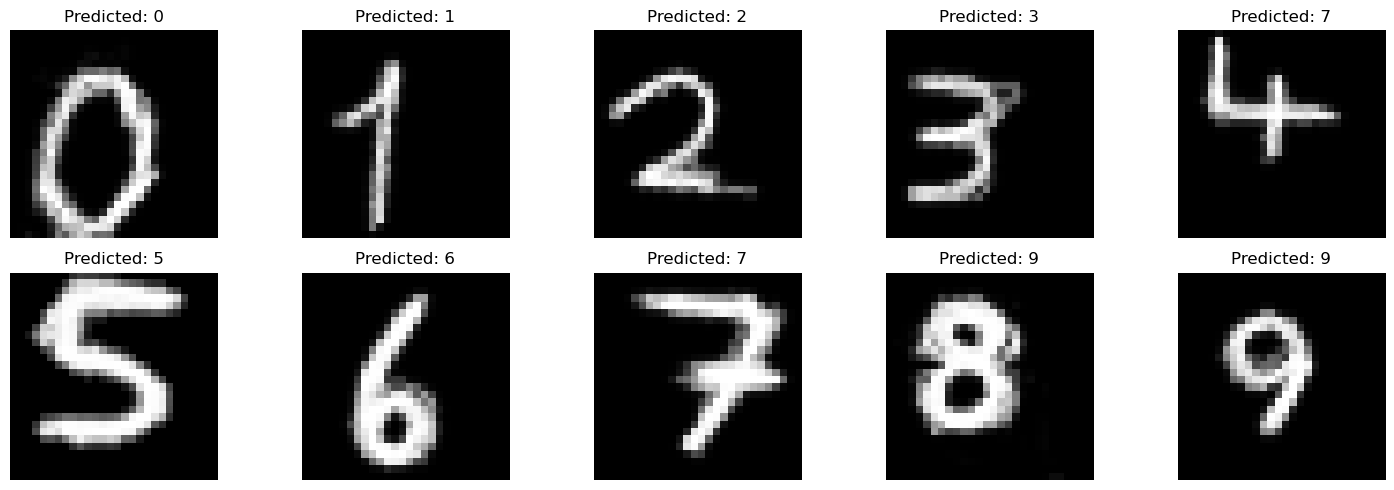

In [25]:
#and another set of digits
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a figure with multiple subplots arranged in a single row
plt.figure(figsize=(15, 5))

# Loop through each digit and plot the prediction
for idx, digit in enumerate(digits, start=1):
    # Load the digit image and preprocess it
    digit_filename = f"./Pictures/Friend/{digit}.png"
    digit_in = Image.open(digit_filename).convert('L') # convert to grayscale
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]

    data /= 255

    # Reshape the data and make prediction
    data = data.reshape(1, xdim, ydim, 1)
    pred = model_CNN.predict(data)

    # Reshape the data for visualization
    data = data.reshape(xdim, ydim)

    # Plot the digit and its predicted label in a subplot
    plt.subplot(2, 5, idx)
    plt.imshow(data, cmap='gray')
    plt.title(f"Predicted: {np.argmax(pred)}")
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rescale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [26]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

0 conv2d
1 conv2d_1
2 max_pooling2d
3 dropout
4 conv2d_2
5 max_pooling2d_1
6 dropout_1
7 flatten
8 dense
9 dropout_2
10 dense_1


Display your filters:

(5, 5, 1, 10)


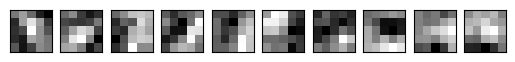

In [27]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [28]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

1/1 [==============================] - 0s 71ms/step


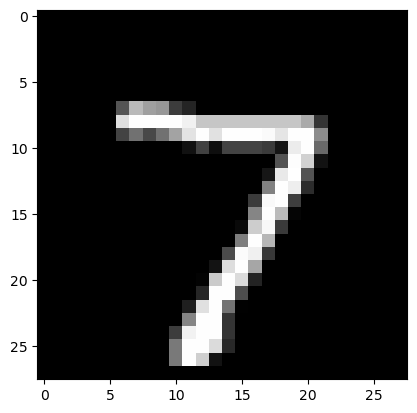

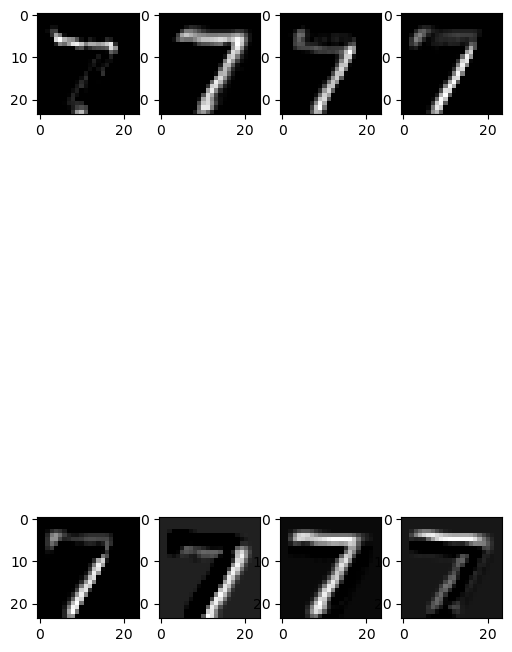

In [29]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer